# 11 Rooms, 11 Maps Experiment (Figure 4)

## Experiment Overview

This notebook implements the multi-room spatial navigation experiment from Figure 4 of the Vector-HaSH paper. The experiment demonstrates how the same grid cell population can represent multiple distinct spatial environments through remapping, while maintaining consistent spatial relationships within each environment.

## Key Concepts

**Spatial Remapping**: The phenomenon where the same set of grid cells can represent different spatial environments by shifting their firing patterns while preserving their fundamental periodic structure.

**Path Integration**: The ability to track position through self-motion cues, implemented here through systematic weight matrix transformations that shift grid cell activity patterns.

**Multi-Environment Navigation**: Testing whether a single grid-place cell network can learn and navigate multiple distinct room layouts.

## Core Parameter Reference Table

| Parameter Category | Parameter | Shape | Meaning | Row/Column Details |
|-------------------|-----------|-------|---------|-------------------|
| **Grid Cell Architecture** | `lambdas` | (4,) | Grid cell periods | [3,4,5,7] - Different spatial scales |
| | `Ng` | scalar | Total grid cells | 99 (3²+4²+5²+7²) |
| | `Npos` | scalar | Spatial positions per axis | 420 (3×4×5×7) |
| | `gbook` | (Ng, Npos, Npos) | Grid cell codebook | Each `gbook[i,:,:]` = spatial firing pattern of grid cell i |
| | `module_sizes` | (4,) | Cells per module | [9,16,25,49] - Squared periods |
| | `module_gbooks` | list of arrays | Identity matrices per module | For modular competition dynamics |
| **Place Cell Network** | `Np` | scalar | Number of place cells | 342 - Intermediate representation layer |
| | `Wpg` | (nruns, Np, Ng) | Grid→Place weights | Random connectivity with sparsity |
| | `pbook` | (nruns, Np, Npos, Npos) | Place cell codebook | Each `pbook[r,i,:,:]` = spatial firing of place cell i in run r |
| | `Wgp` | (Ng, Np) | Place→Grid weights | Learned through associative mapping |
| **Connectivity Parameters** | `c` | scalar | Connection probability | 0.10 - Sparsity level |
| | `mask` | (Np, Ng) | Connectivity mask | Binary mask for sparse connections |
| | `thresh` | scalar | Nonlinearity threshold | 2.0 - For winner-take-all dynamics |
| **Spatial Navigation** | `length` | scalar | Room size per dimension | 10 - Creates 10×10 room |
| | `path_locations` | (100, 2) | Route coordinates | Snake-like trajectory through room |
| | `rooms` | scalar | Number of environments | 11 - Multiple spatial contexts |
| | `path_locations_arr` | (11, 100, 2) | All room trajectories | Each `path_locations_arr[r,:,:]` = route in room r |
| | `Wgg` | (Ng,Ng ) | `Wgg` is the recurrent connection weights matrix between grid cells. | ` W[i,j] `represents the connection weight between the i-th grid cell and the j-th grid cell.|
| **Sequence Learning** | `abook` | (len(path_locations)) | Action sequences | Encoded movement directions |
| | `path_pbook` | (nruns, Np, length²) | Place codes along path | Neural activity during navigation |
| | `path_sbook` | (Ns, length²) | Sensory codes along path | External sensory inputs |
| | `Wsp` | (Ns, Np) | Sensory→Place mapping | Learned sensory associations |
| **Hexagonal Lattice** | `hexgbook_map` | (2, Npos, Npos) | Hexagonal coordinates | Real-world spatial positions |
| | `grid_fields` | (rooms, Ng, 100) | Grid firing in each room |`grid_fields[j, :, :]` represents the activation state of all grid cells throughout the path in the j-th room.|
| | `place_fields` | (rooms, Np, 100) | Place firing in each room | With optional noise injection |
| **Analysis Metrics** | `num_cells` | (rooms+1,) | Cell distribution | Number of cells active in 0,1,2...rooms |
| | `dot_products` | (C(rooms,2), 100) | Cross-room correlations | Similarity between place fields |
| | `room_pairs` | list | Room combinations | All possible pairs for correlation analysis |

## Experimental Design

### 1. Grid-Place Cell Network Setup
- **Multi-scale grid cells**: 4 modules with periods [3,4,5,7]
- **Sparse connectivity**: 10% connection probability between layers
- **Nonlinear dynamics**: Winner-take-all competition with threshold

### 2. Multi-Room Environment
- **Room layout**: 10×10 positions with snake-like traversal pattern
- **Spatial remapping**: Same neural network represents 11 different room locations
- **Coordinate systems**: Both Cartesian and hexagonal lattice representations

### 3. Learning and Navigation
- **Sequence learning**: MLP classifier learns action sequences from place cell activity
- **Path integration**: Weight matrix transformations implement self-motion updates
- **Error tracking**: Monitor reconstruction accuracy at grid, place, and sensory levels

### 4. Analysis Methods
- **Remapping analysis**: Cross-correlation of place fields between rooms
- **Field distribution**: Statistics of how many rooms each cell is active in
- **Visualization**: Grid and place field patterns on hexagonal lattices

## 1. Module Import and Environment Setup

Import necessary libraries and configure the computational environment:

### Core Libraries
- **numpy**: Numerical computations and array operations
- **matplotlib**: Plotting and visualization with custom presentation style
- **scipy**: Scientific computing utilities for spatial analysis
- **sklearn**: Machine learning models for sequence learning

### Custom Modules
- **assoc_utils_np**: Core associative memory functions (`train_gcpc`, etc.)
- **assoc_utils_np_2D**: 2D-specific grid cell operations (`gen_gbook_2d`, `path_integration_Wgg_2d`)
- **seq_utils**: Sequence learning utilities for action prediction

### Configuration
- **Presentation style**: Custom matplotlib style for publication-quality figures
- **Random seed**: For reproducible experiments across multiple runs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import randint
from tqdm import tqdm as tqdm
from src.assoc_utils_np import train_gcpc
from src.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d
from src.seq_utils import *
plt.style.use('./src/presentation.mplstyle')
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

$\textcolor{red}{Ji \ Lab \ newly \ added}$:

If you are using a Windows system and encounter the following warning：


`findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica`

please run the next cell regarding font configuration.

In [ ]:
plt.style.use('./src/presentation.mplstyle')
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['axes.unicode_minus'] = False 

## 2d GC-PC network

## 2. 2D Grid-Place Cell Network Construction

### 2.1 Network Architecture Design

This section constructs the core Vector-HaSH network for 2D spatial navigation:

**Multi-Scale Grid Cell Modules**:
- **Period selection**: `lambdas = [3,4,5,7]` creates 4 modules with different spatial scales
- **Biological motivation**: Different modules capture spatial information at multiple resolutions
- **Total cells**: `Ng = 3² + 4² + 5² + 7² = 99` grid cells across all modules

**Spatial Representation**:
- **Position space**: `Npos = 3×4×5×7 = 420` positions per spatial dimension
- **2D environment**: Creates 420×420 spatial grid for detailed position encoding
- **Grid codebook**: `gbook(Ng, 420, 420)` stores firing patterns for each grid cell

**Place Cell Layer**:
- **Population size**: `Np = 342` place cells for intermediate spatial representation
- **Random connectivity**: Sparse connections from grid cells to place cells
- **Nonlinear processing**: Winner-take-all dynamics with threshold-based competition

In [3]:
nruns=1
Np = 342 #400
lambdas = [3,4,5,7] #[3,4,5] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook.shape     # (Ng, Npos, Npos)

module_sizes = np.square(lambdas)
module_gbooks = [np.eye(i) for i in module_sizes]

Wpg = randn(nruns, Np, Ng) 

### 2.2 Network Parameter Initialization

Initialize the core network parameters and generate the 2D grid cell codebook:

In [4]:
c = 0.10     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)
thresh = 2.0  #2.5 
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  # (nruns, Np, Npos, Npos) 
gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)

### 2.3 Sparse Connectivity and Place Cell Generation

Implement biologically realistic sparse connectivity and generate place cell responses:

**Sparse Connection Implementation**:
- **Connection probability**: `c = 0.10` (10% connectivity)
- **Pruning strategy**: Randomly remove `(1-c) × Np × Ng` connections
- **Biological realism**: Mimics sparse connectivity found in hippocampal circuits

**Place Cell Response Generation**:
- **Nonlinear transformation**: `pbook = nonlin(Wpg @ gbook, thresh=2.0)`
- **Winner-take-all**: Only place cells above threshold remain active
- **Spatial selectivity**: Creates spatially selective place field patterns

In [5]:
Wgp = train_gcpc(pbook_flattened, gbook_flattened,Npatts=Npos*Npos)

### 2.4 Bidirectional Network Training

Train the reverse (place→grid) connections using associative memory principles:

**Objective**: Learn `Wgp` weights that can reconstruct grid cell activity from place cell patterns

**Method**: `train_gcpc()` implements the associative memory training algorithm

**Purpose**: Enable path integration through grid cell pattern completion

# Route through the rooms

## 3. Spatial Environment and Navigation Path Design

### 3.1 Single Room Trajectory Generation

Design systematic exploration paths for thorough spatial coverage and Set the basic spatial parameters for room exploration:


In [6]:
length = 10  

### 3.2 Snake-Pattern Path Generation

Generate a systematic traversal pattern that covers all positions in the room:

**Algorithm**: 
- **Left-to-right** on even rows (y = 0, 2, 4, ...)
- **Right-to-left** on odd rows (y = 1, 3, 5, ...)
- **Result**: Snake-like pattern ensuring complete spatial coverage

**Purpose**: This systematic exploration pattern ensures that:
1. Every position in the 10×10 room is visited exactly once
2. The path is continuous with minimal jumps
3. Learning can capture complete spatial relationships

In [7]:
#trajectory through length x length room
path_locations = []
x=length
y=length
for i in range(y):
    for j in range(x):
        if i%2 == 0:
            path_locations.append((j,i))
        if i%2 == 1:
            k = y-j-1
            path_locations.append((k,i))

### 3.4 Path Visualization

Visualize the generated traversal path to verify complete spatial coverage:

**Visualization elements**:
- **Gray dots**: Individual positions visited
- **Magenta line**: Continuous path showing movement sequence
- **Grid background**: Spatial reference frame

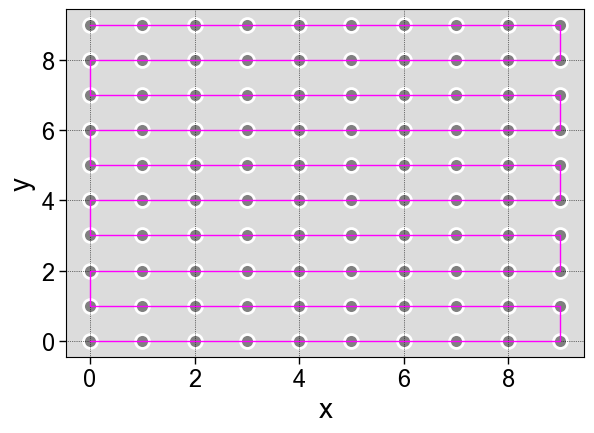

100


In [8]:
plt.figure()
ax = plt.axes()
ax.set_facecolor("gainsboro")
plt.scatter(*zip(*path_locations), color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*path_locations), '-', color="magenta")
plt.ylabel("y", fontsize="20")
plt.xlabel("x", fontsize="20")
plt.grid()
# plt.ylim(-1,4)
# plt.xlim(-1,5)
plt.show()


print(len(path_locations))

## 4. Multi-Room Environment Creation

### 4.1 Spatial Remapping Through Coordinate Translation

Create 11 distinct room environments by translating the basic path pattern:

**Remapping Strategy**:
- **Base pattern**: Use the same snake-like traversal in each room
- **Spatial translation**: Each room occupies a different region of the large coordinate space
- **Random placement**: Room centers chosen randomly within 375×375 coordinate space

**Biological Motivation**:
- **Grid cell remapping**: Same grid cells can represent different environments
- **Preserved relationships**: Spatial structure within each room remains consistent
- **Context discrimination**: Network must learn to distinguish between rooms

In [9]:
# 11 rooms represented through remapping: creating randomly placed rooms
rooms = 11
path_locations_arr = np.ndarray((rooms, length*length, 2), dtype=int)

path_locations_copy = np.copy(path_locations)
# Copy the previously generated 'snake trajectory', the original coordinates (0,0) → (9,0) → ... etc.

# Define the translation amount
C_X = 10
C_Y = 10


for i in range(rooms):
    path_locations_arr[i,:,0] = path_locations_copy[:,0] + C_X
    path_locations_arr[i,:,1] = path_locations_copy[:,1] + C_Y
    
    C_X = np.random.choice(np.arange(20,375,15)) #[20, 25, 50, 100, 200, 225, 250, 300, 350, 360])
    C_Y = np.random.choice(np.arange(20,375,15)) #[20, 25, 50, 100, 200, 225, 250, 300, 350, 360])

### 4.2 Fixed Room Layout for Reproducible Experiments

Define specific room positions for consistent experimental results:

**Design Principles**:
- **Non-overlapping**: Rooms are spatially separated to avoid interference
- **Diverse spacing**: Various distances between rooms test generalization
- **Fixed coordinates**: Reproducible results across experimental runs

**Room Distribution**:
- **Base offset**: All rooms start from (30,30) baseline
- **Scattered layout**: Rooms distributed across 400×400 coordinate space
- **Strategic positioning**: Some rooms close together, others far apart

In [10]:
# 11 rooms represented through remapping: fixed randomization of room locations
rooms = 11
path_locations_arr = np.ndarray((rooms, length*length, 2), dtype=int)
path_locations_copy = np.copy(path_locations)


C_X = 30
C_Y = 30

########
path_locations_arr[0] = path_locations_copy

path_locations_arr[1,:,0] = path_locations_copy[:,0] + C_X + 100
path_locations_arr[1,:,1] = path_locations_copy[:,1] + C_Y + 200

path_locations_arr[2,:,0] = path_locations_copy[:,0] + C_X + 25
path_locations_arr[2,:,1] = path_locations_copy[:,1] + C_Y + 360 

path_locations_arr[3,:,0] = path_locations_copy[:,0] + C_X + 100
path_locations_arr[3,:,1] = path_locations_copy[:,1] + C_Y + 50

path_locations_arr[4,:,0] = path_locations_copy[:,0] + C_X + 150
path_locations_arr[4,:,1] = path_locations_copy[:,1] + C_Y

path_locations_arr[5,:,0] = path_locations_copy[:,0] + C_X + 250
path_locations_arr[5,:,1] = path_locations_copy[:,1] + C_Y + 350 

path_locations_arr[6,:,0] = path_locations_copy[:,0] + C_X + 250
path_locations_arr[6,:,1] = path_locations_copy[:,1] + C_Y + 20

path_locations_arr[7,:,0] = path_locations_copy[:,0] + C_X + 50
path_locations_arr[7,:,1] = path_locations_copy[:,1] + C_Y + 100

path_locations_arr[8,:,0] = path_locations_copy[:,0] + C_X + 200
path_locations_arr[8,:,1] = path_locations_copy[:,1] + C_Y + 150
path_locations_arr[9,:,0] = path_locations_copy[:,0] + C_X + 200
path_locations_arr[9,:,1] = path_locations_copy[:,1] + C_Y + 300 

path_locations_arr[10,:,0] = path_locations_copy[:,0] + C_X + 50
path_locations_arr[10,:,1] = path_locations_copy[:,1] + C_Y + 250

# path_locations_arr[11,:,0] = path_locations_copy[:,0] + C_X + 300
# path_locations_arr[11,:,1] = path_locations_copy[:,1] + C_Y + 225

### 4.3 Individual Room Visualization

Visualize a single room (Room 5) to verify the coordinate transformation:

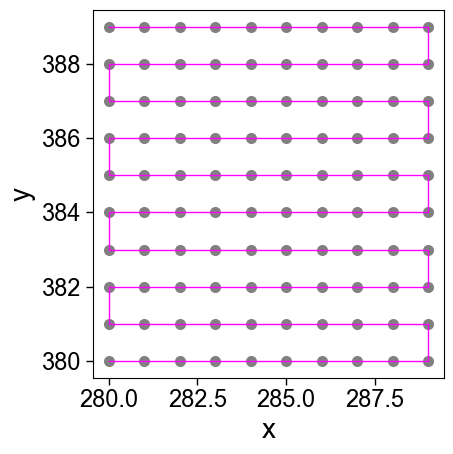

In [11]:
idx = 5
plt.figure(figsize=(5,5))
plt.scatter(*zip(*path_locations_arr[idx]),color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*path_locations_arr[idx]),'-', color="magenta")
plt.ylabel("y", fontsize="20")
plt.xlabel("x", fontsize="20")
#plt.grid()
#ax = plt.axes()
#ax.set_facecolor("gainsboro")
plt.show()

### 4.4 All Rooms Overview

Display all 11 room trajectories simultaneously to show spatial distribution:

**Color coding**: Each room gets a different color for easy identification.

**Layout analysis**: Verify non-overlapping placement and spatial diversity 

*p.s.:* Note that the **small squares** in the diagram actually represent the trajectory, as the translation scale is large, exceeding a trajectory length of 10.

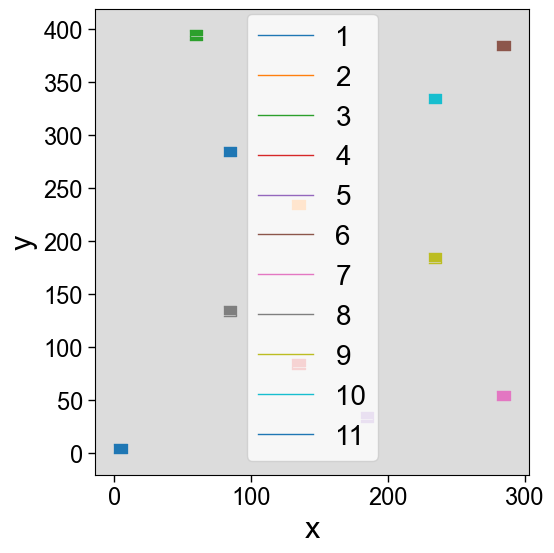

In [12]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_facecolor("gainsboro")

i = 0
for path_locations in path_locations_arr:
    
    #plt.scatter(*zip(*path_locations),color="gray", s=100, edgecolors="white", linewidths=2)
    plt.plot(*zip(*path_locations),'-', label=i+1)
    i+=1

plt.ylabel("y")
plt.xlabel("x")
#plt.grid()

plt.legend(loc="best")
# plt.xlim(0,420)
# plt.ylim(0,420)
plt.show();

# Learning paths in each room through seq learning 

## 5. Sequence Learning and Navigation

### 5.1 Learning Spatial Sequences

This section demonstrates how the network learns to navigate through rooms using sequence learning:

In Fig. 4 we assumed direct v input to help path integrate. We later demonstrated sequence learning in Fig. 5. Here we additionally use sequence learning to learn paths that cover the rooms in the envs considered in Fig. 4. 

### 5.2 Experimental Context and Methodology

**Figure 4 vs Figure 5 Comparison**:
- **Figure 4**: Uses direct velocity input for path integration
- **Figure 5**: Demonstrates full sequence learning capabilities
- **This experiment**: Combines both approaches for comprehensive testing

**Learning Objectives**:
1. **Action prediction**: Learn to predict next movements from place cell activity
2. **Path integration**: Update grid cell representations through learned movements
3. **Sequence completion**: Navigate complete room trajectories autonomously

### 5.3 Single Room Learning Setup

Select Room 0 for detailed sequence learning demonstration:

In [13]:
idx = 0
path_locations = path_locations_arr[idx]    # route 

### 5.4 Sensory Codebook Generation

Create sensory representations for each position in the selected room:

**Sensory encoding**:
- **Pattern count**: `Ns = Npatts = 100` (one pattern per path position)
- **Spatial dimensions**: Match the position space (`Npos × Npos`)
- **Nonlinear processing**: Apply `sens_nonlin()` for realistic sensory responses

In [14]:
Npatts = len(path_locations)
Ns = Npatts 
x,y = Npos ,Npos # Npos, Npos
sbook = sens_nonlin(randn(Ns, x, y))
sbook_flattened = sbook.reshape(Ns, x*y)

### 5.5 Action and Sensory Mapping

Generate action sequences and establish sensory-place cell associations:

**Action sequence encoding**:
- **`abook`**: Action patterns derived from the movement sequence.abook is a one-dimensional vector, where each element represents the action at various positions, for example, 3 represents upward, and 4 represents downward.
- **`path_pbook`**: Place cell activity patterns along the path
- **`path_sbook`**: Sensory patterns along the path

**Mapping establishment**:
- **`Wsp`**: Sensory→Place mapping learned from co-occurrence statistics

In [15]:
abook = actions(path_locations)


path_pbook, path_sbook = path_codes(path_locations, pbook, sbook)  
#Wap = actionmap(abook, path_pbook)  #nruns, Na, Np
#Wap = actionmap(abook, path_PBOOK)  #nruns, Na, Np

# the shape is (Ns,Np)
Wsp = sensorymap(path_sbook, path_pbook)



### 5.6 Action Prediction Network Training

Train a Multi-Layer Perceptron to predict actions from place cell activity:

**Network Architecture**:
- **Input**: Place cell activity patterns (`path_pbook`)
- **Hidden layer**: 250 neurons with ReLU activation
- **Output**: Action sequences (`abook`)
- **Training**: Maximum 12,000 iterations for convergence

**Learning Objective**: Map spatial location (encoded by place cells) to appropriate movement actions

In [16]:
# learn action mapping from place to actions through perceptron algorithm
n_run = 0
X = path_pbook[n_run].T
#X = np.sign(randn(Np, Npatts)).T   # perceptron mapping random patterns
y = abook.T
model = MLPClassifier(hidden_layer_sizes=(250,), activation="relu", random_state=1, max_iter=12000).fit(X, y)
model.fit(X, y)

MLPClassifier(hidden_layer_sizes=(250,), max_iter=12000, random_state=1)

### 5.7 Model Performance Evaluation

Assess the action prediction accuracy on the training data:

*p.s.:* Return the model's accuracy on the training set, measuring the ability to predict actions from the place cell states. However, considering there is no separate test set, overfitting is also quite normal.

In [17]:
model.score(X,y)

1.0

### 5.8 Autonomous Navigation Through Learned Sequences

Test the complete navigation system by predicting the full trajectory:

**Navigation Loop**:
1. **Current state**: Start with initial grid cell activity `g`
2. **Place cell activity**: Compute `p = nonlin(Wpg @ g)`
3. **Action prediction**: Use trained MLP to predict next action
4. **Path integration**: Update grid cell state using `Wgg` transformation
5. **Position decoding**: Decode spatial position from updated grid cells
6. **Error tracking**: Monitor reconstruction accuracy at each step

**Error Metrics**:
- **`err_g`**: Grid cell reconstruction error
- **`err_p`**: Place cell prediction error  
- **`err_s`**: Sensory reconstruction error

**Expected Outcome**: Successful autonomous navigation through the learned room trajectory

In [18]:
# Predicting G, P and S states through learned sequence

# Encode the (x, y) 2D spatial position into a flat index (0 ~ Npos²-1) for easy lookup.
path_locations_flattened = [x*Npos+y for x, y in path_locations]


decoded_path_locations = []

nsteps = len(path_locations_flattened)
n_run=0
k = 0

# Reminder: Each line of gbook_flattened corresponds to a specific grid cell, representing its activation across all spatial locations.
g = gbook_flattened[:,int(path_locations_flattened[0])]

err_g = np.zeros(nsteps)
err_p = np.zeros(nsteps)
err_s = np.zeros(nsteps)
for i in tqdm(path_locations_flattened): 
    # print(k)
    k+=1

    # Decode the current grid vector into coordinates (return the nearest ground truth coordinates).
    decoded_path_locations.append(gcode_to_coord(g[None,:,None], gbook_flattened,Npos))
    
    err_g[k-1] = np.sum(np.abs(g.flatten()-gbook_flattened[:,i]))
    
    # Utilise the learned Grid → Place weights to map g to the p state.
    p = nonlin(Wpg@g, thresh=thresh)
        
    err_p[k-1] = np.sum(np.abs(p[n_run].flatten()-pbook_flattened[n_run,:,i]))/(2*Np)
    
    # s.shape =  (nruns, Ns, 1)
    s = np.sign(Wsp@p[:,:,None])
    err_s[k-1] = np.linalg.norm(s[n_run].flatten()-sbook_flattened[:,i])/(2*Ns)
        
    
    a = model.predict(p[:1])
    action = int(a[n_run])      # run0

    # 1d actions
    axis, direction = oneDaction_mapping(action)
    if axis == None:
        continue
    # print("Action: ", axis, direction)
    
    if isinstance(axis, list):
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis[0], direction=direction[0])  
        g = Wgg@g
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis[1], direction=direction[1])
        g = Wgg@g
    else:
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis, direction=direction)
        g = Wgg@g
    np.squeeze(g)

print("max g error at any step = "+str(np.amax(err_g)))
print("max p error at any step = "+str(np.amax(err_p)))
print("max s error at any step = "+str(np.amax(err_s)))

100%|██████████| 100/100 [00:00<00:00, 103.95it/s]


max g error at any step = 0.0
max p error at any step = 3.895519384649672e-18
max s error at any step = 0.0


### 5.9 Navigation Results Comparison

Compare the learned trajectory with the original path to assess navigation accuracy:

**Top plot**: Decoded path from autonomous navigation

**Bottom plot**: Original target trajectory with starting position marked

**Success metrics**:
- **Path similarity**: How closely the decoded path matches the original
- **Coverage completeness**: Whether all intended positions are reached
- **Sequential accuracy**: Correct ordering of position visits

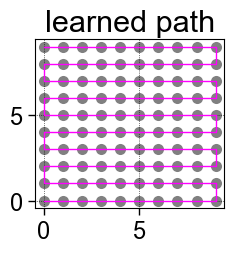

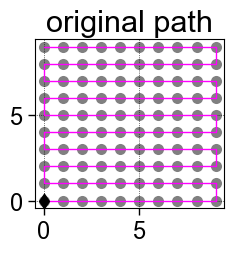

In [19]:
plt.figure(figsize=(3,3))
plt.scatter(*zip(*decoded_path_locations), color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*decoded_path_locations), '-', color="magenta")
plt.title('learned path');
plt.grid()
plt.show()

plt.figure(figsize=(3,3))
plt.scatter(*zip(*path_locations), color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*path_locations), '-', color="magenta")
plt.plot(*path_locations[0], 'd-', color="black")
plt.title('original path');
plt.grid()
plt.show()


## 6. Hexagonal Lattice Visualization and Analysis

### 6.1 Biological Realism Through Hexagonal Grids
Transition from Cartesian to hexagonal coordinate systems for biological accuracy:

### 6.2 Hexagonal Grid Data Loading

Load pre-computed hexagonal lattice coordinates for realistic spatial representation:

**Data source**: `pos420by420.mat` contains hexagonal grid positions

**Biological motivation**: Real grid cells fire in hexagonal patterns, not square grids.

**Coordinate mapping**: Transform between Cartesian room coordinates and hexagonal lattice positions

In [20]:
import scipy.io 
mat = scipy.io.loadmat('pos420by420.mat')
hexgbook_map = mat["newpos"]

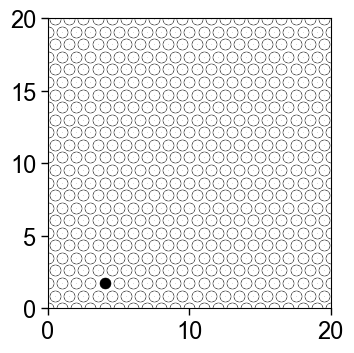

In [21]:
plt.figure(figsize = (4,4))
plt.scatter(hexgbook_map[0,:,:],hexgbook_map[1,:,:],linewidth = 8,color = 'k', s=0.1)   #Makes hexagonal grid
plt.plot(hexgbook_map[0,4,2], hexgbook_map[1,4,2], 'ko')
plt.xlim(0,20)
plt.ylim(0,20)
plt.show()

In [22]:
cell_idx = 35
grid_fields = gbook_flattened[cell_idx]

cell_idx = 35
place_fields = np.squeeze(pbook_flattened)[cell_idx]

(0.0, 20.0)

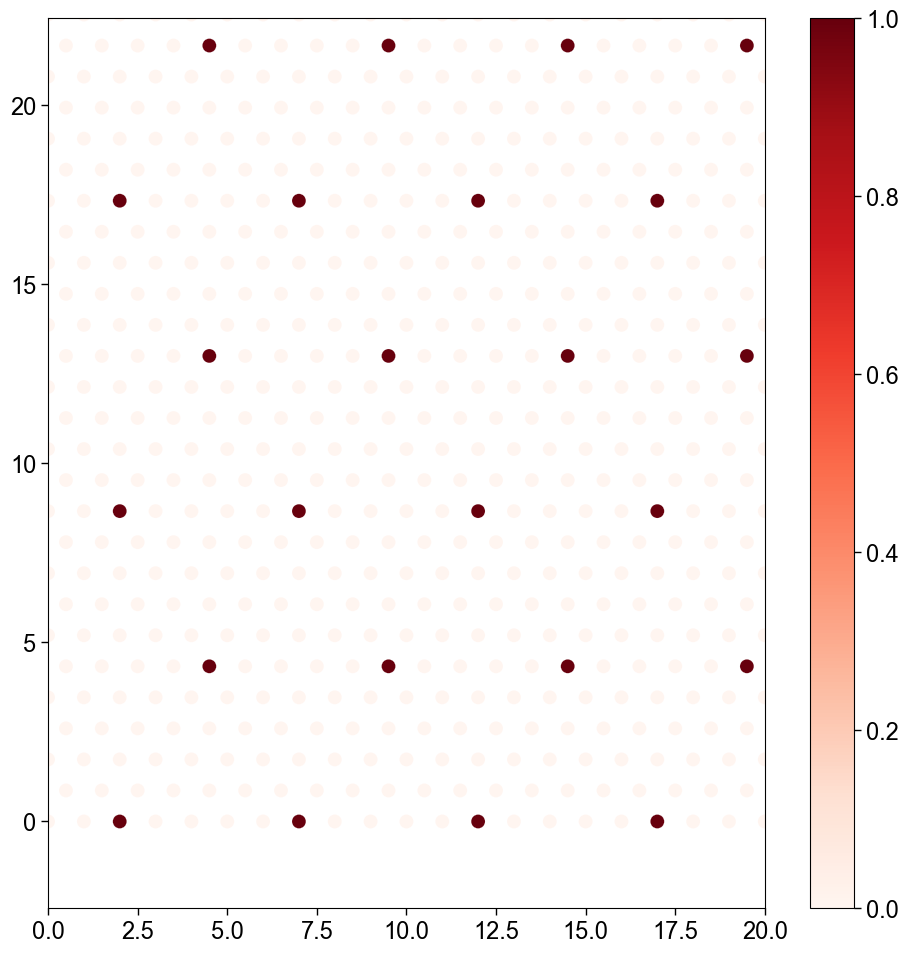

In [23]:
plt.figure(figsize = (10,10))
plt.scatter((hexgbook_map[0,:,:]+ np.arange(Npos)//2)%Npos, hexgbook_map[1,:,:], c=grid_fields, s=100, edgecolors="white", linewidths=0.1, cmap = 'Reds')
plt.colorbar()
plt.axis('equal')
plt.xlim(0,20)
plt.ylim(0,20) 

### Plot Grid Fields (see also Grid_place_tuning_curves_and_additional_expts_Fig1_4_6.ipynb)

In [24]:
hex_path_locations_arr = np.ndarray((rooms, length*length, 2))
for i in range(rooms):
    hex_path_locations_arr[i] = mapRealtoHex(hexgbook_map, path_locations_arr[i])

In [25]:
nrun = 0
grid_fields = np.ndarray((rooms, Ng, length*length))

for j in range(rooms):
    for i in range(length*length):
        # The activation state vector of all 99 grid cells at the i-th waypoint in the j-th room. This is a one-dimensional array with a length of 99.
        grid_fields[j,:,i] = (gbook[:,path_locations_arr[j][i][0], path_locations_arr[j][i][1]])
  

In [26]:
#place fields (w noise, can be set to zero)
nrun = 0
place_fields = np.ndarray((rooms, Np, length*length))

for j in range(rooms):
    for i in range(length*length):
        place_fields[j,:,i] = (pbook[nrun,:,path_locations_arr[j][i][0], path_locations_arr[j][i][1]] + np.random.uniform(low=0, high=0.05))
        

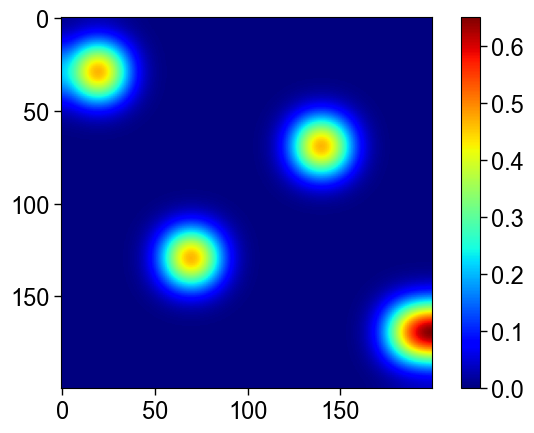

In [27]:
room_idx = 8
cell_idx = 30
grid_fields_ex = grid_fields[room_idx, cell_idx]

gbook_prenonlin = np.squeeze(Wgp@place_fields[room_idx])
grid_fields_prenonlin = gbook_prenonlin[cell_idx]

#use below lines if want grid fields as average of pre- and post- CAN dynamics, potentially representative of a time average
# maxfr_gf = np.max(grid_fields_ex)
# maxfr_gfpre = np.max(grid_fields_prenonlin)
# avg_fields = np.mean((grid_fields_prenonlin/maxfr_gfpre, grid_fields_ex/maxfr_gf), axis=0)
# hexed_afs = smooth_tuningcurve(avg_fields, 10, mult=2)

#use below lines if want grid fields post- CAN dynamics
hexed_afs = smooth_tuningcurve(grid_fields_ex, 10, mult=2)

hexed_afs_up_smooth = explicit_interpolation(hexed_afs, sigma=10)

fig = plt.figure()

plt.imshow(hexed_afs_up_smooth, cmap='jet')
plt.colorbar();

$\textcolor{red}{Ji \ Lab \ newly \ added}$:

One main function of the smooth_tuningcurve is rolling, with the aim of making the firing position appear more hexagonal. What would the result look like if we didn't apply this function?

Text(0.5, 1.0, 'Direct Plot (Square Grid)')

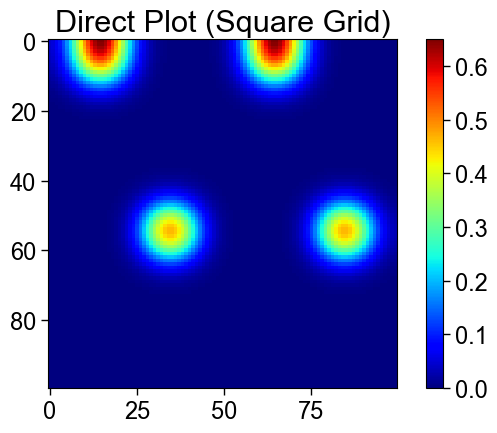

In [28]:

original_field = grid_fields_ex.reshape(10, 10)
original_field = explicit_interpolation(original_field, sigma=5)

fig = plt.figure()
plt.imshow(original_field, cmap='jet', interpolation='nearest') 
plt.colorbar();
plt.title("Direct Plot (Square Grid)")

In [28]:
cell_idx = 111
room_idx = 9

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

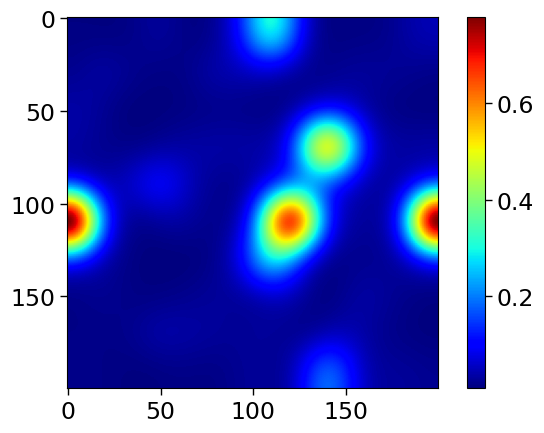

In [69]:
hexed_afs = smooth_tuningcurve(place_fields[room_idx,cell_idx], 10, mult=2)
hexed_afs_up_smooth = explicit_interpolation(hexed_afs, sigma=10)
fig = plt.figure()
plt.imshow(hexed_afs_up_smooth, cmap='jet')
plt.colorbar();

## Frequency Distribution 

## 7. Multi-Room Place Field Analysis

### 7.1 Place Cell Activity Distribution Across Rooms

Analyze how place cells distribute their activity across multiple room environments:

In [70]:
nrun = 0
place_fields = np.ndarray((rooms, Np, length*length))

for j in range(rooms):
    for i in range(length*length):
        place_fields[j,:,i] = pbook[nrun,:,path_locations_arr[j][i][0], path_locations_arr[j][i][1]]

The core objective of this function is to analyse the activity distribution of place cells across multiple different environments (rooms). 

Specifically, it aims to answer the following question:

"Of all the place cells, how many cells are active in **only 1 room**? How many are active in 2 rooms? How many are active in all 11 rooms? And how many are **inactive in any room**?"

In [71]:
def numcells(place_fields, threshold):
    active_place_fields = (place_fields>threshold)*1
    
    # number of rooms in which a given place cell is active
    num_rooms = np.zeros((Np))
    for cell_idx in range(Np):
        for room_idx in range(rooms):
            num_fields = np.sum(active_place_fields[room_idx,cell_idx,:])
            if num_fields > 0:
                num_rooms[cell_idx] += 1


    # number of cells active in zero, one, two ... (rooms+1) rooms
    num_cells = np.zeros((rooms+1))

    for i in range(rooms+1):
        num_cells[i] = np.count_nonzero(num_rooms == i)         
    
    return num_cells

In [72]:
num_cells_0p1 = numcells(place_fields, 0.5)
num_cells_0p5 = numcells(place_fields, 0.75)
num_cells_1 = numcells(place_fields, 1.0)

In simple terms, this chart is showing a statistical distribution, with the primary aim of answering: 

"To what extent are place cells **'specific'**?"

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

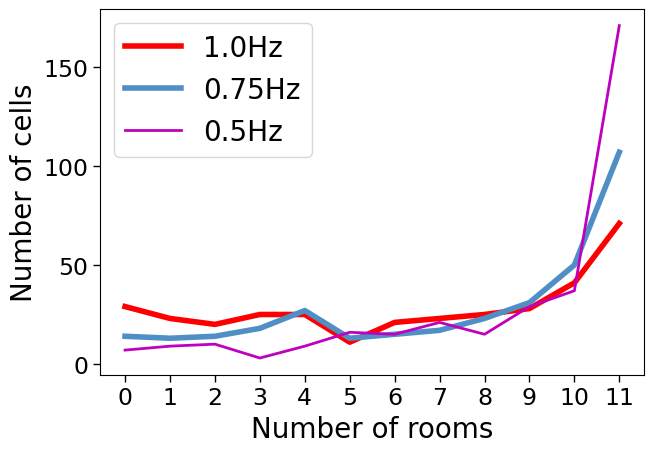

In [73]:
fig = plt.figure(figsize=(7,5))
plt.plot(range(rooms+1), num_cells_1, 'r', linewidth=4, label="1.0Hz")
plt.plot(range(rooms+1), num_cells_0p5, '#4f8fc6', linewidth=4, label="0.75Hz")
plt.plot(range(rooms+1), num_cells_0p1, 'm', linewidth=2, label="0.5Hz")
plt.xlabel("Number of rooms", fontsize=20)
plt.ylabel("Number of cells", fontsize=20)
plt.legend()
plt.xticks(range(rooms+1));

## Checking overlap/correlation between place fields across rooms

In [ ]:
# For each place cell, identify its maximum firing rate across all rooms and all locations. 
# This is equivalent to finding the "excitement peak" of each cell.
cell_maxfr = np.max(place_fields, axis=(0,2))

cell_maxfr[cell_maxfr==0]=1
cell_maxfr.shape

(342,)

In [774]:
tile = np.array(rooms*[cell_maxfr])
tile = np.array([tile]*100)
tile.shape

(100, 11, 342)

In [775]:
cell_maxfr_tiled = np.moveaxis(tile, 0, -1)
cell_maxfr_tiled.shape

(11, 342, 100)

In [776]:
normalized_place_fields = np.divide(place_fields, cell_maxfr_tiled)

In [777]:
test = np.copy(normalized_place_fields)

In [778]:
# Shuffle fields
for i in range(1000):
    rng = np.random.default_rng()
    #rng.shuffle(normalized_place_fields, axis=0)
    rng.shuffle(normalized_place_fields, axis=1)
#     rng.shuffle(normalized_place_fields, axis=2)

In [780]:
# generate all nC2 combinations of rooms
from itertools import combinations
room_pairs = []
for combo in combinations(np.arange(rooms), 2):  # 2 for pairs, 3 for triplets, etc
    room_pairs.append(combo)
    
num_room_pairs = len(room_pairs)  
num_room_pairs

55

For each room pairing (for example, room A and room B), the code will compare their "population neural activity vectors" at the same position along the path.

 You can imagine that at each step along the path, there is a list containing the firing rates of all `Np` position cells. The `einsum` function calculates the dot product of this list from room A and this list from room B.

In [781]:
dot_products = np.ndarray((num_room_pairs, length*length))

i = 0
for pair in room_pairs:
    field_pair = normalized_place_fields[pair,:,:]  # 2 x Np x (length*length)
    dot_products[i] = np.einsum('jk, jk -> k', field_pair[0], field_pair[1]) / Np
    i+=1
    
avg_dot_products = np.mean(dot_products, axis=1)
avg_dot_products.shape    

(55,)

In [782]:
dot_products_id = np.ndarray((rooms, length*length))   # dot product of identical rooms, room with itself

for i in range(rooms):
    dot_products_id[i] = np.einsum('jk, jk -> k', normalized_place_fields[0,:,:], normalized_place_fields[0,:,:]) / Np
    i+=1
    
avg_dot_products_id = np.mean(dot_products_id, axis=1)
avg_dot_products_id.shape    

(11,)

In [783]:
mat = np.zeros((rooms, rooms))

i = 0
for pair in room_pairs:
    mat[pair[0], pair[1]] = mat[pair[1], pair[0]] = avg_dot_products[i]
    i+=1

i = 0    
for i in range(rooms):
    mat[i,i] = avg_dot_products_id[i]
    i+=1

In [784]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

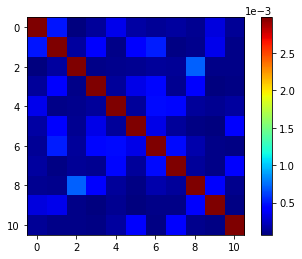

In [785]:
import matplotlib.ticker as ticker

fig = plt.figure()
plt.imshow(mat, cmap='jet')
#plt.colorbar(format=ticker.FuncFormatter(fmt))


cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))


## Multiple visits to two rooms

In [29]:
place_fields.shape

(11, 342, 100)

In [ ]:
new_rooms = rooms+3
mulvisit_place_fields = np.ndarray((new_rooms, Np, length*length))

#The first six rooms remain unchanged (rooms 0-5).
mulvisit_place_fields[:6] = place_fields[:6]

#Repeatedly visit room 1 and room 0.
mulvisit_place_fields[6] = place_fields[1] #noisy_place_fields[1]
mulvisit_place_fields[7] = place_fields[0] #noisy_place_fields[0]


mulvisit_place_fields[8:13] = place_fields[6:]

mulvisit_place_fields[13] = place_fields[6] #noisy_place_fields[6]

In [949]:
cell_maxfr = np.max(mulvisit_place_fields, axis=(0,2))
cell_maxfr[cell_maxfr==0]=1
cell_maxfr.shape

(342,)

In [950]:
tile = np.array(new_rooms*[cell_maxfr])
tile = np.array([tile]*100)
tile.shape

(100, 14, 342)

In [951]:
cell_maxfr_tiled = np.moveaxis(tile, 0, -1)
cell_maxfr_tiled.shape

(14, 342, 100)

In [952]:
normalized_place_fields = np.divide(mulvisit_place_fields, cell_maxfr_tiled)
test = np.copy(normalized_place_fields)

In [953]:
# Shuffle fields
for i in range(1000):
    rng = np.random.default_rng()
    #rng.shuffle(normalized_place_fields, axis=0)
    rng.shuffle(normalized_place_fields, axis=1)
#     rng.shuffle(normalized_place_fields, axis=2)

In [954]:
# generate all nC2 combinations of rooms
from itertools import combinations
room_pairs = []
for combo in combinations(np.arange(new_rooms), 2):  # 2 for pairs, 3 for triplets, etc
    room_pairs.append(combo)
    
num_room_pairs = len(room_pairs)  
num_room_pairs

91

In [955]:
dot_products = np.ndarray((num_room_pairs, length*length))

i = 0
for pair in room_pairs:
    field_pair = normalized_place_fields[pair,:,:]  # 2 x Np x (length*length)
    dot_products[i] = np.einsum('jk, jk -> k', field_pair[0], field_pair[1]) / Np
    i+=1
    
avg_dot_products = np.mean(dot_products, axis=1)
avg_dot_products.shape 

(91,)

In [956]:
dot_products_id = np.ndarray((new_rooms, length*length))   # dot product of identical rooms, room with itself

for i in range(new_rooms):
    dot_products_id[i] = np.einsum('jk, jk -> k', normalized_place_fields[0,:,:], normalized_place_fields[0,:,:]) / Np
    i+=1
    
avg_dot_products_id = np.mean(dot_products_id, axis=1)
avg_dot_products_id.shape    

(14,)

In [957]:
mat = np.zeros((new_rooms, new_rooms))

i = 0
for pair in room_pairs:
    mat[pair[0], pair[1]] = mat[pair[1], pair[0]] = avg_dot_products[i]
    i+=1

i = 0    
for i in range(new_rooms):
    mat[i,i] = avg_dot_products_id[i]
    i+=1

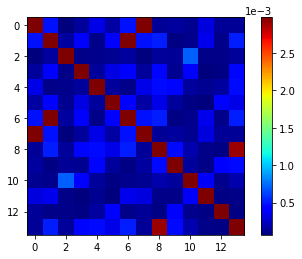

In [962]:
import matplotlib.ticker as ticker

fig = plt.figure()
plt.imshow(mat, cmap='jet')
#plt.colorbar(format=ticker.FuncFormatter(fmt))


cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))